# Observational study 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotnine
import networkx as nx
from plotnine import ggplot, aes, geom_bar
from functions import *
import statsmodels.formula.api as smf
import spacy
import time
import datetime
import yfinance as yf
import scipy.stats as ss

In [2]:
from popularity import trending_history
from financials import *
from compare import *

In [3]:
data = pd.read_csv('data/FinalFeatures3.csv.bz2')

In [4]:
data

,company,date,close,volume,money_volume,marketcap,popularity,Elon,compare,sentiment,numOccurrences
0,Apple,2015-02-05,27.025118,174826400.0,4.724704e+09,4.433849e+11,38,1,NaN,-0.1761,31
1,Microsoft,2015-02-05,37.361649,34616600.0,1.293333e+09,2.805105e+11,30,0,Apple,0.0000,0
2,IBM,2015-02-05,111.899719,3406299.0,3.811639e+08,1.002980e+11,4,0,Apple,0.0000,0
3,Samsung,2015-02-05,23147.441406,8005050.0,1.852964e+11,1.381851e+14,100,0,Apple,0.0000,0
4,Lenovo,2015-02-05,20.973963,57300.0,1.201808e+06,1.262811e+10,17,0,Apple,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...
3849,General Motors,2020-04-15,20.870001,11501700.0,2.400405e+08,3.030032e+10,3,0,Tesla,0.0000,0
3850,Tesla,2020-04-16,150.778000,65641000.0,9.897219e+09,1.514203e+11,100,1,NaN,0.2553,2
3851,Daimler,2020-04-16,27.833939,8416127.0,2.342540e+08,2.977675e+10,16,0,Tesla,0.0000,0
3852,VolksWagen,2020-04-16,117.395157,2322531.0,2.726539e+08,2.420747e+10,63,0,Tesla,0.0000,0


In [5]:
#the currencies are wrong
#korean won has been about 1050x during the period
data['marketcap'] = np.where(data['company'] == 'Samsung', data['marketcap']/1050, data['marketcap'])
data['money_volume'] = np.where(data['company'] == 'Samsung', data['money_volume']/1050, data['money_volume'])
data['close'] = np.where(data['company'] == 'Samsung', data['close']/1050, data['close'])

#HKD is about 7.8 in the period
data['marketcap'] = np.where(data['company'] == 'Lenovo', data['marketcap']/7.8, data['marketcap'])
data['money_volume'] = np.where(data['company'] == 'Lenovo', data['money_volume']/7.8, data['money_volume'])
data['close'] = np.where(data['company'] == 'Lenovo', data['close']/7.8, data['close'])

#EUR has been between 0.8 and 0.95, we'll put 0.88
data['marketcap'] = np.where(data['company'] == 'BMW', data['marketcap']/0.88, data['marketcap'])
data['money_volume'] = np.where(data['company'] == 'BMW', data['money_volume']/0.88, data['money_volume'])
data['close'] = np.where(data['company'] == 'BMW', data['close']/0.88, data['close'])
data['marketcap'] = np.where(data['company'] == 'Dailmer', data['marketcap']/0.88, data['marketcap'])
data['money_volume'] = np.where(data['company'] == 'Dailmer', data['money_volume']/0.88, data['money_volume'])
data['close'] = np.where(data['company'] == 'Dailmer', data['close']/0.88, data['close'])
data['marketcap'] = np.where(data['company'] == 'VolksWagen', data['marketcap']/0.88, data['marketcap'])
data['money_volume'] = np.where(data['company'] == 'VolksWagen', data['money_volume']/0.88, data['money_volume'])
data['close'] = np.where(data['company'] == 'VolksWagen', data['close']/0.88, data['close'])
data['marketcap'] = np.where(data['company'] == 'Renault', data['marketcap']/0.88, data['marketcap'])
data['money_volume'] = np.where(data['company'] == 'Renault', data['money_volume']/0.88, data['money_volume'])
data['close'] = np.where(data['company'] == 'Renault', data['close']/0.88, data['close'])
data

,company,date,close,volume,money_volume,marketcap,popularity,Elon,compare,sentiment,numOccurrences
0,Apple,2015-02-05,27.025118,174826400.0,4.724704e+09,4.433849e+11,38,1,NaN,-0.1761,31
1,Microsoft,2015-02-05,37.361649,34616600.0,1.293333e+09,2.805105e+11,30,0,Apple,0.0000,0
2,IBM,2015-02-05,111.899719,3406299.0,3.811639e+08,1.002980e+11,4,0,Apple,0.0000,0
3,Samsung,2015-02-05,22.045182,8005050.0,1.764728e+08,1.316049e+11,100,0,Apple,0.0000,0
4,Lenovo,2015-02-05,2.688970,57300.0,1.540780e+05,1.618988e+09,17,0,Apple,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...
3849,General Motors,2020-04-15,20.870001,11501700.0,2.400405e+08,3.030032e+10,3,0,Tesla,0.0000,0
3850,Tesla,2020-04-16,150.778000,65641000.0,9.897219e+09,1.514203e+11,100,1,NaN,0.2553,2
3851,Daimler,2020-04-16,27.833939,8416127.0,2.342540e+08,2.977675e+10,16,0,Tesla,0.0000,0
3852,VolksWagen,2020-04-16,133.403587,2322531.0,3.098340e+08,2.750849e+10,63,0,Tesla,0.0000,0


## Matching : 

In [6]:
add_propensityscore(data)

Optimization terminated successfully.
         Current function value: 0.247418
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   Elon   No. Observations:                 3854
Model:                          Logit   Df Residuals:                     3850
Method:                           MLE   Df Model:                            3
Date:                Fri, 17 Dec 2021   Pseudo R-squ.:                  0.5530
Time:                        19:13:19   Log-Likelihood:                -953.55
converged:                       True   LL-Null:                       -2133.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.7439      0.076     -9.792      0.000      -0.893      -0.595
money_volume     7.6827

In [7]:
data

,company,date,close,volume,money_volume,marketcap,popularity,Elon,compare,sentiment,numOccurrences,propensity_score
0,Apple,2015-02-05,-0.439593,5.353629,1.558639,3.962498,-0.178602,1,NaN,-0.1761,31,0.970719
1,Microsoft,2015-02-05,-0.360119,0.608581,0.129482,2.237701,-0.367744,0,Apple,0.0000,0,0.013713
2,IBM,2015-02-05,0.212982,-0.447653,-0.250434,0.329297,-0.982453,0,Apple,0.0000,0,0.019927
3,Samsung,2015-02-05,-0.477882,-0.292020,-0.335688,0.660829,1.287243,0,Apple,0.0000,0,0.021557
4,Lenovo,2015-02-05,-0.626706,-0.560991,-0.409124,-0.715688,-0.675098,0,Apple,0.0000,0,0.051231
...,...,...,...,...,...,...,...,...,...,...,...,...
3849,General Motors,2020-04-15,-0.486918,-0.173684,-0.309212,-0.411960,-1.006096,0,Tesla,0.0000,0,0.050420
3850,Tesla,2020-04-16,0.511906,1.658524,3.712978,0.870669,1.287243,1,NaN,0.2553,2,1.000000
3851,Daimler,2020-04-16,-0.433374,-0.278108,-0.311622,-0.417505,-0.698741,0,Tesla,0.0000,0,0.059660
3852,VolksWagen,2020-04-16,0.378319,-0.484330,-0.280143,-0.441525,0.412465,0,Tesla,0.0000,0,0.142171


We can see that Toyota gets low propensity score because it has a large market cap and low volume

In [8]:
data[data['company'] == 'Toyota'][:4]

,company,date,close,volume,money_volume,marketcap,popularity,Elon,compare,sentiment,numOccurrences,propensity_score
420,Toyota,2015-06-02,0.360196,-0.554798,-0.396073,1.190129,0.436107,0,Ford,0.0,0,0.002982
425,Toyota,2016-04-21,0.166397,-0.546899,-0.388306,0.820263,0.436107,0,Ford,0.0,0,0.006426
430,Toyota,2016-07-21,0.183286,-0.555962,-0.399923,0.852496,0.459750,0,Ford,0.0,0,0.005608
435,Toyota,2017-02-16,0.226824,-0.554795,-0.397804,0.935588,0.530678,0,Ford,0.0,0,0.005074


BMW on the other hand gets higher propensity_scores because it ahs lower market cap and higher volume.
Ideally we would have included more covariates, but it's hard to find good observable covariates for the stock markets, and if we had used categories, it would have been better to have more varied data or else it could have overfitted to one type of category.

In [9]:
data[data['company'] == 'BMW'][:4]

,company,date,close,volume,money_volume,marketcap,popularity,Elon,compare,sentiment,numOccurrences,propensity_score
421,BMW,2015-06-02,0.021988,-0.487128,-0.327972,-0.177835,0.790747,0,Ford,0.0,0,0.079937
426,BMW,2016-04-21,-0.100118,-0.490855,-0.346051,-0.279078,0.932603,0,Ford,0.0,0,0.090994
431,BMW,2016-07-21,-0.126222,-0.530835,-0.382414,-0.300721,0.743462,0,Ford,0.0,0,0.065761
436,BMW,2017-02-16,-0.060439,-0.518919,-0.367840,-0.246178,0.814390,0,Ford,0.0,0,0.068898


In [10]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [11]:
def matchingfunction(data):
    treatment_df = data[data['Elon'] == 1]
    control_df   = data[data['Elon'] == 0]
    # Create an empty undirected graph
    G = nx.Graph()
    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            if (control_row['compare']== treatment_row['company']) and (control_row['date']== treatment_row['date']) :
                # Calculate the similarity 
                similarity = get_similarity(control_row['propensity_score'],
                                    treatment_row['propensity_score'])
                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])
    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    return matching

In [12]:
b = matchingfunction(data)

In [13]:
b

{(0, 4),
 (9, 5),
 (10, 14),
 (19, 15),
 (24, 20),
 (25, 29),
 (34, 30),
 (35, 36),
 (40, 44),
 (49, 45),
 (50, 54),
 (59, 55),
 (60, 61),
 (65, 69),
 (74, 70),
 (75, 79),
 (80, 84),
 (89, 85),
 (90, 92),
 (97, 95),
 (104, 100),
 (105, 109),
 (112, 110),
 (115, 117),
 (120, 124),
 (129, 125),
 (130, 134),
 (139, 135),
 (144, 140),
 (145, 147),
 (154, 150),
 (155, 159),
 (160, 163),
 (168, 165),
 (170, 173),
 (179, 175),
 (184, 180),
 (185, 189),
 (193, 190),
 (195, 197),
 (200, 202),
 (209, 205),
 (210, 211),
 (216, 215),
 (220, 222),
 (224, 225),
 (228, 230),
 (232, 235),
 (236, 238),
 (240, 243),
 (244, 247),
 (248, 250),
 (252, 254),
 (256, 259),
 (260, 263),
 (264, 265),
 (268, 269),
 (272, 274),
 (276, 279),
 (280, 283),
 (284, 287),
 (288, 289),
 (292, 293),
 (296, 297),
 (300, 302),
 (304, 305),
 (308, 310),
 (312, 314),
 (316, 318),
 (320, 323),
 (324, 327),
 (328, 331),
 (332, 335),
 (336, 339),
 (340, 343),
 (344, 347),
 (353, 349),
 (354, 357),
 (362, 359),
 (364, 367),
 (36

In [14]:
tesla_match = []
apple_match = []
twitter_match = []
ford_match = []
paypal_match = []
for pair in b:
    l = (data.iloc[int(pair[0])]['company'], data.iloc[int(pair[1])]['company'], data.iloc[int(pair[0])]['date'])
    if 'Tesla' in l:
        tesla_match.append(l)
    elif 'Apple' in l:
        apple_match.append(l)
    elif 'Twitter' in l:
        twitter_match.append(l)
    elif 'Ford' in l:
        ford_match.append(l)
    elif 'PayPal' in l:
        paypal_match.append(l)
apple_match[0:8]

[('Lenovo', 'Apple', '2015-05-14'),
 ('Lenovo', 'Apple', '2018-08-11'),
 ('Lenovo', 'Apple', '2015-02-24'),
 ('Apple', 'Lenovo', '2015-02-21'),
 ('Lenovo', 'Apple', '2015-10-10'),
 ('Lenovo', 'Apple', '2016-07-03'),
 ('Apple', 'Lenovo', '2015-05-06'),
 ('Apple', 'IBM', '2018-11-02')]

In [15]:
tesla_match

[('Tesla', 'VolksWagen', '2018-07-12'),
 ('VolksWagen', 'Tesla', '2019-09-09'),
 ('VolksWagen', 'Tesla', '2016-07-30'),
 ('VolksWagen', 'Tesla', '2019-09-28'),
 ('VolksWagen', 'Tesla', '2016-08-12'),
 ('VolksWagen', 'Tesla', '2015-01-30'),
 ('Tesla', 'VolksWagen', '2015-09-14'),
 ('Tesla', 'VolksWagen', '2015-10-10'),
 ('VolksWagen', 'Tesla', '2017-11-13'),
 ('General Motors', 'Tesla', '2017-07-31'),
 ('VolksWagen', 'Tesla', '2019-12-24'),
 ('Tesla', 'General Motors', '2018-06-05'),
 ('VolksWagen', 'Tesla', '2017-02-01'),
 ('Tesla', 'VolksWagen', '2018-09-11'),
 ('Tesla', 'General Motors', '2017-09-14'),
 ('Tesla', 'VolksWagen', '2018-02-25'),
 ('VolksWagen', 'Tesla', '2019-03-13'),
 ('Tesla', 'VolksWagen', '2019-06-26'),
 ('VolksWagen', 'Tesla', '2018-02-20'),
 ('Tesla', 'VolksWagen', '2016-04-30'),
 ('Tesla', 'VolksWagen', '2016-05-11'),
 ('Tesla', 'VolksWagen', '2018-11-09'),
 ('VolksWagen', 'Tesla', '2018-03-12'),
 ('VolksWagen', 'Tesla', '2020-04-02'),
 ('VolksWagen', 'Tesla', '20

In [16]:
apple_match[:15]

[('Lenovo', 'Apple', '2015-05-14'),
 ('Lenovo', 'Apple', '2018-08-11'),
 ('Lenovo', 'Apple', '2015-02-24'),
 ('Apple', 'Lenovo', '2015-02-21'),
 ('Lenovo', 'Apple', '2015-10-10'),
 ('Lenovo', 'Apple', '2016-07-03'),
 ('Apple', 'Lenovo', '2015-05-06'),
 ('Apple', 'IBM', '2018-11-02'),
 ('Apple', 'Lenovo', '2015-10-09'),
 ('Apple', 'Lenovo', '2015-10-12'),
 ('Apple', 'Microsoft', '2015-03-12'),
 ('Microsoft', 'Apple', '2020-03-12'),
 ('Lenovo', 'Apple', '2018-08-10'),
 ('Samsung', 'Apple', '2017-07-17'),
 ('Lenovo', 'Apple', '2017-06-14')]

In [17]:
first_date = data.iloc[0]['date']

In [18]:
tesla_c = {'Tesla' : stock_history('Tesla', first_date, '2021-01-01'),
            'Daimler' : stock_history('Daimler', first_date, '2021-01-01'),
            'Lucid' : stock_history('Lucid', first_date, '2021-01-01'),
            'VolksWagen' : stock_history('VolksWagen', first_date, '2021-01-01'),
            'General Motors' : stock_history('General Motors', first_date, '2021-01-01')}

In [19]:
apple_c = {'Apple' : stock_history('Apple', first_date, '2021-01-01'),
            'IBM' : stock_history('IBM', first_date, '2021-01-01'),
            'Samsung' : stock_history('Samsung', first_date, '2021-01-01'),
            'Lenovo' : stock_history('Lenovo', first_date, '2021-01-01'),
            'Microsoft' : stock_history('Microsoft', first_date, '2021-01-01')}

In [20]:
twitter_c = {'Twitter' : stock_history('Twitter', first_date, '2021-01-01'),
            'Google' : stock_history('Google', first_date, '2021-01-01'),
            'Facebook' : stock_history('Facebook', first_date, '2021-01-01'),
            'Snapchat' : stock_history('Snapchat', first_date, '2021-01-01'),
            'Pinterest' : stock_history('Pinterest', first_date, '2021-01-01')}

In [21]:
ford_c = {'Ford' : stock_history('Ford', first_date, '2021-01-01'),
            'Toyota' : stock_history('Toyota', first_date, '2021-01-01'),
            'BMW' : stock_history('BMW', first_date, '2021-01-01'),
            'General Motors' : stock_history('General Motors', first_date, '2021-01-01'),
            'Stellantis' : stock_history('Stellantis', first_date, '2021-01-01')}

In [22]:
paypal_c = {'PayPal' : stock_history('PayPal', first_date, '2021-01-01'),
            'Western Union' : stock_history('Western Union', first_date, '2021-01-01'),
            'EuroNet' : stock_history('Euro net', first_date, '2021-01-01'),
            'MoneyGram' : stock_history('MoneyGram', first_date, '2021-01-01'),
            'Visa' : stock_history('Visa', first_date, '2021-01-01')}

In [23]:
def hist_from_hist(hist, start_date, end_date):
    internal_np = []
    for i in range(len(hist)):
        if hist.iloc[i].name.date() < datetime.date.fromisoformat(start_date):
            start = i
        if hist.iloc[i].name.date() > datetime.date.fromisoformat(end_date):
            end = i-1
            break
    return hist.copy().iloc[start:end]
def get_dates_c(start_date, weeks, days):
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = start_date + dt.timedelta(weeks=weeks, days=days)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
def dailyChangeC(hist, start_date, end_date):
    df = hist_from_hist(hist, start_date, end_date)
    result = []
    for i in range(len(df)-1):
        changeFromPreviousDay = 1-(df.iloc[i+1]['Close']/df.iloc[i]['Close'])
        result.append(float(changeFromPreviousDay))
    dates = [*df.index]
    dates = [*map(lambda n: n.strftime("%Y-%m-%d"), dates)]
    dates = dates[1:]
    return result, dates

In [24]:
dailyChangeC(apple_c['Apple'], '2015-03-10', '2015-03-15')

([0.020685863836669593, 0.018231423804493163, -0.018079157805630297],
 ['2015-03-10', '2015-03-11', '2015-03-12'])

In [25]:
days = 5

In [26]:
def change_distributions(company_match, company_c):
    co = {[*company_c.keys()][0] : {'x' : [], 'y' : []},
        [*company_c.keys()][1] : {'x' : [], 'y' : []},
        [*company_c.keys()][2] : {'x' : [], 'y' : []},
        [*company_c.keys()][3] : {'x' : [], 'y' : []},
        [*company_c.keys()][4] : {'x' : [], 'y' : []}}
    
    for i in range(len(company_match)):
        dates = get_dates_c(company_match[i][2], 0, days)
        comp1 = company_match[i][0]
        try:
            temp, _ = dailyChangeC(company_c[comp1], dates[0], dates[1])
            co[comp1]['x'].extend(temp)
            co[comp1]['y'].extend([*range(len(temp))])
        except:
            print('error with:', comp1)

        comp2 = company_match[i][1]
        try:
            temp, _ = dailyChangeC(company_c[comp2], dates[0], dates[1])
            co[comp2]['x'].extend(temp)
            co[comp2]['y'].extend([*range(len(temp))])
        except:
            print('error with:', comp2)

    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(15,5))
    ax1.scatter([*co.values()][0]['y'], [*co.values()][0]['x'])
    ax1.set_title([*co.keys()][0])
    ax2.scatter([*co.values()][1]['y'], [*co.values()][1]['x'], label=[*co.keys()][1])
    ax2.set_title([*co.keys()][1])
    ax3.scatter([*co.values()][2]['y'], [*co.values()][2]['x'], label=[*co.keys()][2])
    ax3.set_title([*co.keys()][2])
    ax4.scatter([*co.values()][3]['y'], [*co.values()][3]['x'], label=[*co.keys()][3])
    ax4.set_title([*co.keys()][3])
    ax5.scatter([*co.values()][4]['y'], [*co.values()][4]['x'], label=[*co.keys()][4])
    ax5.set_title([*co.keys()][4])
    
    return co

error with: Lenovo


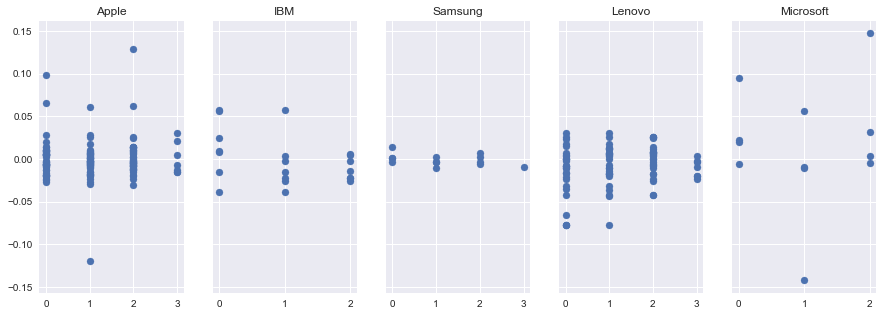

In [27]:
apple_dist = change_distributions(apple_match, apple_c)

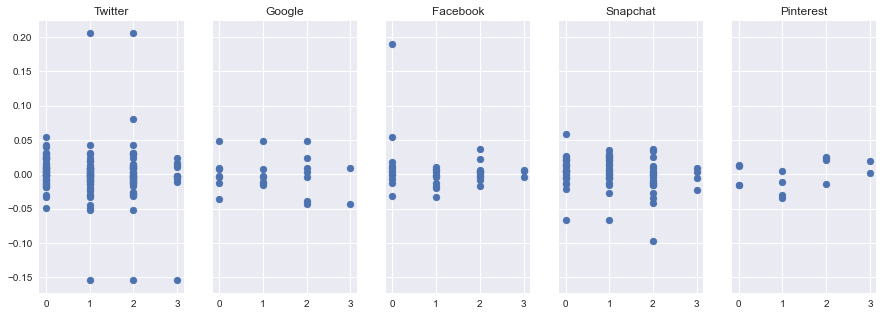

In [28]:
twitter_dist = change_distributions(twitter_match, twitter_c)

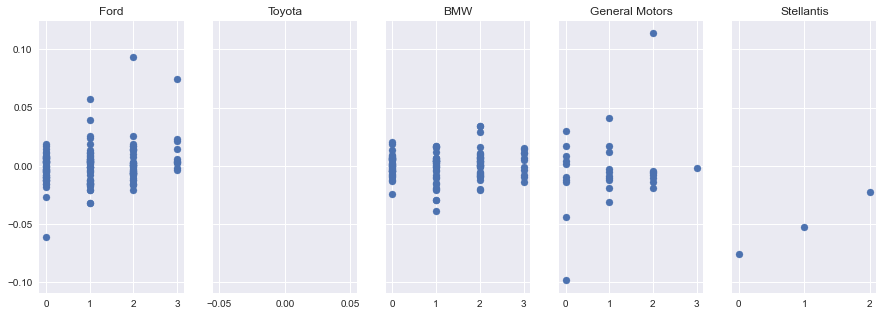

In [29]:
ford_dist = change_distributions(ford_match, ford_c)

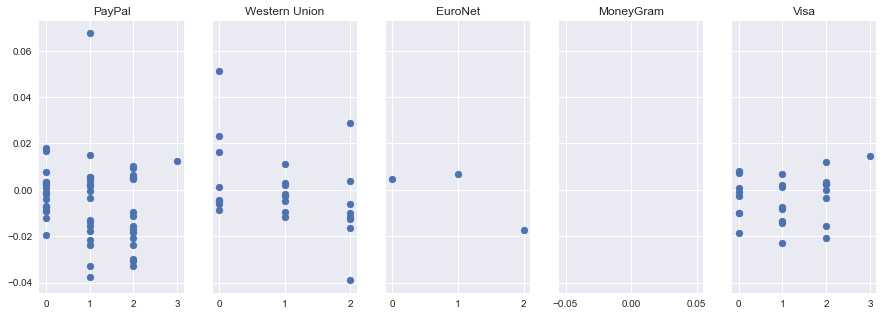

In [30]:
paypal_dist = change_distributions(paypal_match, paypal_c)

error with: VolksWagen
error with: Tesla
error with: VolksWagen
error with: Tesla
error with: VolksWagen
error with: VolksWagen
error with: Tesla
error with: Tesla
error with: VolksWagen
error with: VolksWagen
error with: Tesla
error with: Tesla
error with: VolksWagen
error with: Tesla
error with: VolksWagen


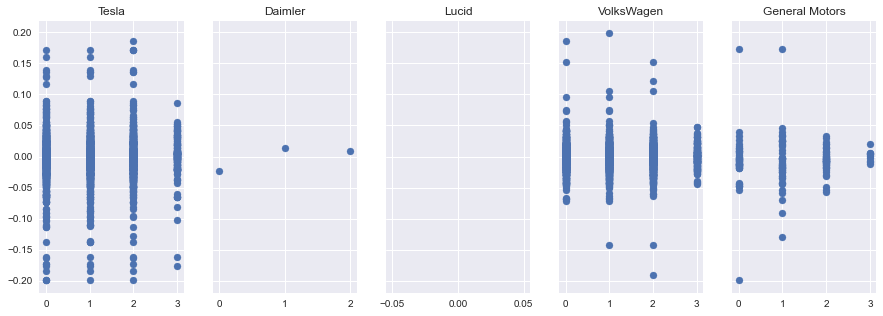

In [31]:
tesla_dist = change_distributions(tesla_match, tesla_c)

### Test on distribution

In [32]:
import scipy

In [33]:
apple_dists = np.c_[np.asarray(apple_dist['Apple']['x']),
                np.asarray(apple_dist['IBM']['x']),
                np.asarray(apple_dist['Samsung']['x']),
                np.asarray(apple_dist['Lenovo']['x']),
                np.asarray(apple_dist['Microsoft']['x'])]
plt.boxplot(apple_dists, labels=['Apple','IBM','Samsung','Lenovo','Microsoft'])
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 137 and the array at index 1 has size 21

In [ ]:
def anova_oneway(comp_dist):
    A = comp_dist[[*comp_dist.keys()][0]]['x']
    B = comp_dist[[*comp_dist.keys()][1]]['x']
    C = comp_dist[[*comp_dist.keys()][2]]['x']
    D = comp_dist[[*comp_dist.keys()][3]]['x']
    E = comp_dist[[*comp_dist.keys()][4]]['x']
    return scipy.stats.f_oneway(A,B,C,D,E)

In [ ]:
anova_oneway(apple_dist)

In [ ]:
anova_oneway(twitter_dist)

In [ ]:
anova_oneway(ford_dist)

In [ ]:
A = ford_dist[[*ford_dist.keys()][0]]['x']
C = ford_dist[[*ford_dist.keys()][2]]['x']
D = ford_dist[[*ford_dist.keys()][3]]['x']
E = ford_dist[[*ford_dist.keys()][4]]['x']
scipy.stats.f_oneway(A,C,D,E)

In [ ]:
anova_oneway(paypal_dist)

In [ ]:
A = paypal_dist[[*paypal_dist.keys()][0]]['x']
C = paypal_dist[[*paypal_dist.keys()][1]]['x']
D = paypal_dist[[*paypal_dist.keys()][2]]['x']
E = paypal_dist[[*paypal_dist.keys()][4]]['x']
scipy.stats.f_oneway(A,C,D,E)

In [ ]:
anova_oneway(tesla_dist)

In [ ]:
A = tesla_dist[[*tesla_dist.keys()][0]]['x']
C = tesla_dist[[*tesla_dist.keys()][1]]['x']
D = tesla_dist[[*tesla_dist.keys()][3]]['x']
E = tesla_dist[[*tesla_dist.keys()][4]]['x']
scipy.stats.f_oneway(A,C,D,E)

### F-score

In [ ]:
p_value = scipy.stats.f.cdf(F, df1, df2)

### t-test

In [ ]:
apple_match[:20]

In [ ]:
def t_distributions(company_match, company_c):
    co = {[*company_c.keys()][1] : {'main' : {'x' : [], 'y' : []},
                                    'match' : {'x' : [], 'y' : []}},
        [*company_c.keys()][2] : {'main' : {'x' : [], 'y' : []},
                                    'match' : {'x' : [], 'y' : []}},
        [*company_c.keys()][3] : {'main' : {'x' : [], 'y' : []},
                                    'match' : {'x' : [], 'y' : []}},
        [*company_c.keys()][4] : {'main' : {'x' : [], 'y' : []},
                                    'match' : {'x' : [], 'y' : []}}}
    
    for i in range(len(company_match)):
        dates = get_dates_c(company_match[i][2], 0, days)
        if company_match[i][0] == [*company_c.keys()][0]:
            other_comp = company_match[i][1]
        else:
            other_comp = company_match[i][0]
            
        try:
            temp1, dat = dailyChangeC(company_c[other_comp], dates[0], dates[1])
            co[other_comp]['match']['x'].extend(temp1)
            co[other_comp]['match']['y'].extend(dat)
            
            temp2, dat = dailyChangeC(company_c[[*company_c.keys()][0]], dates[0], dates[1])
            co[other_comp]['main']['x'].extend(temp2)
            co[other_comp]['main']['y'].extend(dat)
        except:
            print('error with:', other_comp)
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True,figsize=(15,5))

    i = 0
    for ax in [ax1,ax2,ax3,ax4]:
        #np.unique(np.asarray(
        main_x = [*co.values()][i]['main']['x']
        main_y = [*co.values()][i]['main']['y']
        match_x = [*co.values()][i]['match']['x']
        match_y = [*co.values()][i]['match']['y']
        
        ax.scatter(match_y, match_x, label=[*co.keys()][i])
        ax.scatter(main_y, main_x, label=[*company_c.keys()][0])
        ax.set_title([*co.keys()][i] + '/' + [*company_c.keys()][0])
        ax.axes.get_xaxis().set_visible(False)
        i += 1
    
    fig.legend()
    fig.savefig('figures/observational{}.svg'.format([*company_c.keys()][0]))
    fig.show()
    
    return co

In [ ]:
apple_dist = t_distributions(apple_match, apple_c)

In [ ]:
for comp in apple_dist:
    print(comp,ss.mannwhitneyu(apple_dist[comp]['main']['x'], apple_dist[comp]['match']['x']))

In [ ]:
twitter_dist = t_distributions(twitter_match, twitter_c)

In [ ]:
for comp in twitter_dist:
    print(comp,ss.mannwhitneyu(twitter_dist[comp]['main']['x'], twitter_dist[comp]['match']['x']))

In [ ]:
ford_dist = t_distributions(ford_match, ford_c)

In [ ]:
for comp in ford_dist:
    try:
        print(comp,ss.mannwhitneyu(ford_dist[comp]['main']['x'], ford_dist[comp]['match']['x']))
    except:
        print('empty')

In [ ]:
paypal_dist = t_distributions(paypal_match, paypal_c)

In [ ]:
for comp in paypal_dist:
    try:
        print(comp,ss.mannwhitneyu(paypal_dist[comp]['main']['x'], paypal_dist[comp]['match']['x']))
    except:
        print('empty')

In [ ]:
tesla_dist = t_distributions(tesla_match, tesla_c)

In [ ]:
for comp in tesla_dist:
    try:
        print(comp,ss.mannwhitneyu(tesla_dist[comp]['main']['x'], tesla_dist[comp]['match']['x']))
    except:
        print('empty')